In [2]:
#Implement a Dataloader read directly from the image folders

import os
import torch

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [27]:
class LazyLoadDataset(Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        surface_volume_paths, ink_label_path = self.samples[idx]

        surface_volume_images = [Image.open(path) for path in surface_volume_paths]
        ink_label_image = Image.open(ink_label_path)

        if self.transform:
            surface_volume_images = [self.transform(image) for image in surface_volume_images]
            ink_label_image = self.transform(ink_label_image)

        return surface_volume_images, ink_label_image

In [28]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []  # To store tuples of (surface_volume_paths, ink_label_path)

        for class_name in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                surface_volume_dir = os.path.join(class_dir, "surface_volume")
                ink_label_path = os.path.join(class_dir, "inklabels.png")
                surface_volume_paths = [os.path.join(surface_volume_dir, filename) for filename in os.listdir(surface_volume_dir)]
                self.samples.append((surface_volume_paths, ink_label_path))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        surface_volume_paths, ink_label_path = self.samples[idx]

        return surface_volume_paths, ink_label_path

In [29]:
# Define the root directory of your dataset
root_dir = '../../Datasets/vesuvius-challenge-ink-detection/train'

In [30]:
# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Create the CustomDataset
dataset = CustomDataset(root_dir, transform=transform)
lazy_dataset = LazyLoadDataset(dataset.samples, transform=transform)

# Create DataLoader
batch_size = 1
train_loader = DataLoader(lazy_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

In [ ]:
# Get a batch of data from the DataLoader
batch = next(iter(train_loader))
surface_volume_images, ink_label_images = batch

In [26]:
surface_volume_images[0].shape

torch.Size([1, 1, 7606, 5249])

In [22]:
ink_label_images.shape

torch.Size([1, 1, 7606, 5249])

In [23]:
import matplotlib.pyplot as plt
import numpy as np

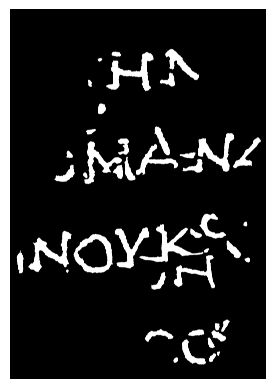

In [24]:
# Display the grayscale image
plt.imshow(ink_label_images.squeeze(0).squeeze(0), cmap="gray") #last [] is the layer
plt.axis("off")
plt.show()

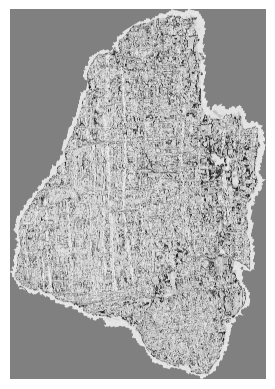

In [25]:
# Display the grayscale image
plt.imshow(surface_volume_images[0].squeeze(0).squeeze(0), cmap="gray") #last [] is the layer
plt.axis("off")
plt.show()